# Modeling and Forecasting Atmospheric CO2 from 1958 into the future

        Jeong woo Park(Minerva Univeristy/Minerva Schools at KGI), Fall 2021

## Details about the data
The CO2 level in the air(unit:ppm) data is collected from Mauna Loa Observatory in Hawaii. It has 2 columns (date, CO2 ppm-density of particles measurement) and the measurement starts from 1958. Having 3242 values in the dataset, we make two variables for each column, t for time representation(by the number of days since measurements started) and x_t for the CO2 density of time t. The measurement has been collected once in every week. 

## Summary of the tasks done
From the data (weekly_in_situ_co2_mlo.csv), this assignment contains the statistical model that explains the dataset well and use it to focast what measurements will look like between now and the start of 2060. 

Also, it reflects the uncertainty of the prediction by having wide confidence intervals as the time gets further into the future. 

Finally, there is a red line that describes the high-risk levels of CO2, and this will tell us when the world will have a serious climate change. 

## Models of the Assignment 
This model includes three components as the data itself seems to have noise, seasonal trend, and an overall rising trend. 

### Before I start the actual modelling (Just by looking at the data itself)
 - The overall trend itself, when zoomed in it seems to be linear. However, when the whole data is seen, I can see some curvature, and gives me a guess that it will be something quadratic or exponential. Considering human interventions to nature is growing by percentages (like human population growth or etc), it is plausible to guess that CO2 density(ppm) has an overall trend of exponential growth. But we'll see which one fits the most along the way. (Spoiler Alert :  It seems that quadratic increase has the best fit for the given data). 

 - Also, there is a seasonal component. It seems that during the winter, the CO2 level rises, while summer makes a drop in CO2 level. This fluctuatuion due CO2 is more consumed by the plants for growth in summer, while Humans burn more petrolium, woods, and etc during winter for warmth. The seasons in Northern and Southern hemisphere are opposite. But as the atmospheric mixing is pretty slow, and having Mauna Loa situated in the northern hemisphere, the data is likely to only consider the northern hemisphere itself and the trend in southern hemisphere to be having similar trend according to their seasonal changes(thus same logic from this modeling applies, it is only the season of north and south are opposite to each other). As this task and model only catches the trend and forcasts the future, exact reasons about why this trend happens cannot be driven with evidence from only this data. It only can show the correlation between the seasons and the CO2 level increase or decrease.
 
 - There is also a random fluctuations happening every week as there are sometimes a gigantic leap and decrease of CO2 levels that does not follow the major trend nor seasonal fluctuations. Because of the noise, however, we need to make a random fluctuation in the model for noise to account for these real life random fluctuations of CO2 density in ppm. This will be represented as an inverse-gamma distribution with parameter (1,1) (it is known to have low values such as 1 or 0.01 or 0.001) as an attempt of noninformativeness within the conditionally conjugate family(Andrew, 2006) for stan code. But the parameter itself is going to act as a variance for the likelihood function which is a normal distribution. 

In [1]:
#Importing environment setup for google colab
import pandas as pd
from google.colab import files
uploaded = files.upload()
import io
#now import the data using the lambda function that I've learned from class 
data = pd.read_csv(io.BytesIO(uploaded['weekly_in_situ_co2_mlo.csv']), header = None, names = ['date','CO2'], skiprows = lambda x:x in list(range(44))) 

#The data should start with 1958-03-29
data.head()

Saving weekly_in_situ_co2_mlo.csv to weekly_in_situ_co2_mlo.csv


,date,CO2
0,1958-03-29,316.19
1,1958-04-05,317.31
2,1958-04-12,317.69
3,1958-04-19,317.58
4,1958-04-26,316.48


In [2]:
#Preparing the environment
import pystan
import scipy.stats as sts
from scipy import optimize
import math
import random
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
import seaborn as sns
from sklearn.metrics import r2_score

##Graphs of the data itself

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


1959-01-03
1959-12-26


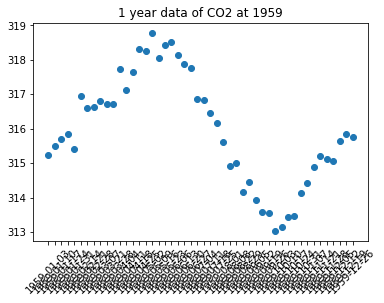

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


1962-12-22
1963-01-05


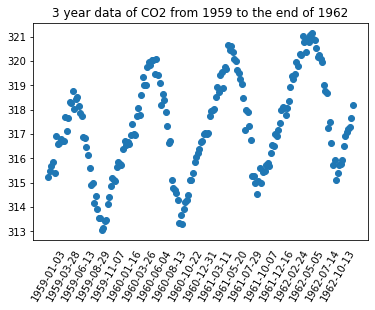

In [3]:
#How about a smaller domain?
print(data.date[25]) #start of the year 1959, row 70 of csv file
print(data.date[72]) #the last day of the year 1959, row 117 of csv file
plt.plot_date(data.date[25:73], data.CO2[25:73], xdate=True)
plt.xticks(rotation = 45)
plt.title("1 year data of CO2 at 1959")
plt.show() #1 year trend
#There seems to be a noise in the seasonal trend
print(data.date[225]) #let's try 1959~1962. This is the last day of 1962
print(data.date[226])
plt.plot_date(data.date[25:226], data.CO2[25:226], xdate=True)
plt.tick_params(bottom = False) #if the ticks are needed, comment this line to see the ticks
plt.xticks(np.arange(0,199,step=10), rotation = 60) #limit the xtick label as it is hard to see them
plt.title("3 year data of CO2 from 1959 to the end of 1962")
plt.show()
#it seems that CO2 levels rise during winter and decrease during summer

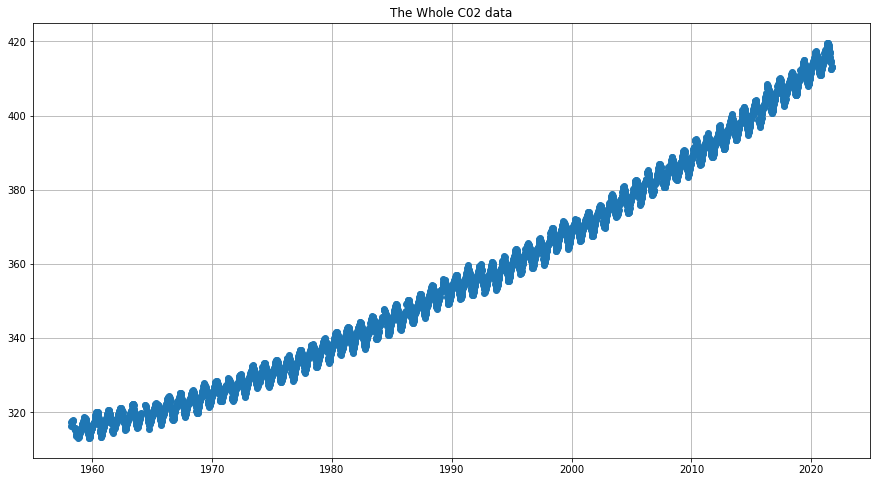

In [4]:
#Let's see how the data looks like before we do anything
data['date'] = pd.to_datetime(data['date'], format = '%Y/%m/%d')
data[0:3]
plt.figure(figsize=(15,8))
plt.plot_date(data.date, data.CO2, xdate=True)
plt.title("The Whole C02 data")
plt.grid(True)
plt.show()
#It seems that the whole data has a trend of increase in exponential

### Making a training data and testing data. 
I am going to split the data in 4:1 ratio, thus 20% will be used as a testing data to test the result of the prediction model. 

Method to split the data is to make another array that only contains the multiple of 5's index of the original data. This means that the data with index 0, 5, 10, and so on will become a testing data. 

---or---
I am going to make some test data that is near the modern days as testing whether the past is perfectly correct or not may fall into overfitting. 

##Modeling 
Let's first test out what model should we use for the data (likelihood) as it seems that our function of the major trend seems to have a curve. What I will test is 1. Quadratic and 2. Exponential. 

The measure of fit is r^2 value, that calculates the errors. I will choose the model that is closer to 1. 

But before we start, it seems a bit hard for me to keep going back to the csv file to find what is the date of the year and manually find the specific data. And as there are no more need of specific date, let's make the date in the representation of epoch. 

In [5]:
#Making date to Epoch
epoch_0 = data.date[0]
print(epoch_0) #first day of the data for us to use
#since there may be a need to use the exact date again, instead of replacing the existing column
#make a new column 'epoch'
data['epoch'] = (data.date-epoch_0).dt.days
#see if the result is comming out correctly
data.head()

1958-03-29 00:00:00


,date,CO2,epoch
0,1958-03-29,316.19,0
1,1958-04-05,317.31,7
2,1958-04-12,317.69,14
3,1958-04-19,317.58,21
4,1958-04-26,316.48,28


1. Quadratic trend
- if I say time is variable 'x'
- major trend: Quadratic(c0x^2 + c1x +c2)
- seasonal variation: Sinusoidal (c3*cos(2*(x/365)*pi + c4))
- Noise: Normal distribution of mean 0 and a standard deviation(c5). 

Then the likelihood function will be 
Normal distribution with a mean of "major trend + seasonal variation" with a variance of (c5)^2. 

Here, we want to see the r^2 and all the other constant values(coefficients) from the data. But, before we start using the model, let's see how the major trend fits the data (thus only working on the major trend for r^2 first and choose the best between quadratic or exponential before we dive in to the coefficients for the seasonal and the noise). 

In [6]:
#Trying quadratic. 
##fitting the coefficients
cs = np.polyfit(data.epoch, data.CO2, deg=2) #coefficients for the quadratic
print("Coefficients: (c0) "+ str(cs[0])+",(c1) "+str(cs[1])+",(c2) "+str(cs[2]))
data['function_quad_major'] = np.array(cs[0]*(data.epoch**2)+cs[1]*(data.epoch)+cs[2]) #function for major trend
print(data.head()) #check if it is done right
data['error'] = data.CO2 - data.function_quad_major
print(data.head())

#calculating r squared
r2_quad = r2_score(data.CO2, data.function_quad_major)
print(r2_quad)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


Coefficients: (c0) 1.000687493904157e-07,(c1) 0.0020446421008328223,(c2) 314.738786745675
        date     CO2  epoch  function_quad_major
0 1958-03-29  316.19      0           314.738787
1 1958-04-05  317.31      7           314.753104
2 1958-04-12  317.69     14           314.767431
3 1958-04-19  317.58     21           314.781768
4 1958-04-26  316.48     28           314.796115
        date     CO2  epoch  function_quad_major     error
0 1958-03-29  316.19      0           314.738787  1.451213
1 1958-04-05  317.31      7           314.753104  2.556896
2 1958-04-12  317.69     14           314.767431  2.922569
3 1958-04-19  317.58     21           314.781768  2.798232
4 1958-04-26  316.48     28           314.796115  1.683885
0.9941461438457619


2. Exponential Major Trend
- if I say that time is variable 'x' again
- major trend: Exponential (c0+e^(c1*x))
- Seasonal variation (same as quadratic)
- Noise (same as quadratic model)

Thus, the likelihood function becomes
'mean' = exponential major trend + seasonal variation
'variance' = from the noise (variance of noise)



In [7]:
#Trying Exponential
def exp_major(time, c0,c1,c2,c3):
  #division of 365 as time is in epoch for seasonal trend (to make it a radian - frequency to repeat over the year, it is necessary)
  return c0+np.exp(c1*time) + c2*np.cos(2*math.pi*time/365+c3) 

cs, cs_var = optimize.curve_fit(exp_major, data.epoch, data.CO2, p0=(1,1e-5,1,1))
print(cs)
data['function_exp_major'] =  exp_major(data.epoch, cs[0],cs[1],cs[2],cs[3]) #function for major trend
data['error_exp'] = data.CO2 - data.function_exp_major
print(data.head())

#calculating r squared
r2_exp = r2_score(data.CO2, data.function_exp_major)
print(r2_exp)

[ 3.34263609e+02  2.00712859e-04  2.85383191e+00 -5.08966453e-01]
        date     CO2  epoch  ...     error  function_exp_major  error_exp
0 1958-03-29  316.19      0  ...  1.451213          337.755714 -21.565714
1 1958-04-05  317.31      7  ...  2.556896          337.906210 -20.596210
2 1958-04-12  317.69     14  ...  2.922569          338.018405 -20.328405
3 1958-04-19  317.58     21  ...  2.798232          338.090690 -20.510690
4 1958-04-26  316.48     28  ...  1.683885          338.122039 -21.642039

[5 rows x 7 columns]
0.8605990006754108


It seems that quadratic function is the better choice as the data has less error with the given major trend's model. (comparing the r^2, quadratic model(0.994) has the higher value than exponential model(0.860))

So, we choose quadratic model for the major trend. 
Here, let's build up the rest parts of the quadratic model. (The noise and the seasonal trend)

The thing is that as the model can't be perfectly fitting the data, (because it may cause over-fitting), even though we add the noise with normal distribution, it will still have the error. 

Let's see how it will look like if I make the seasonal trend added to the quadratic model. (Thus, the noise and error will not be differentiated yet in the graph)





[ 9.97919108e-08  2.04985867e-03  3.14734272e+02  2.86832318e+00
 -5.55294339e-01] These are the coefficients


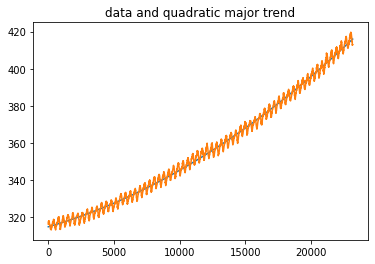

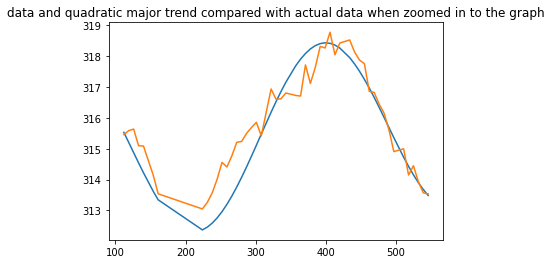

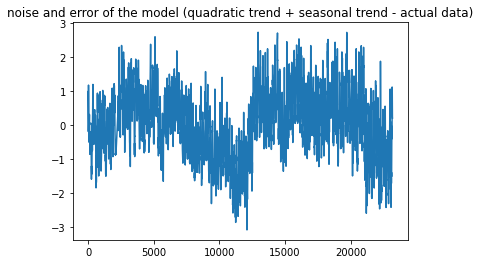

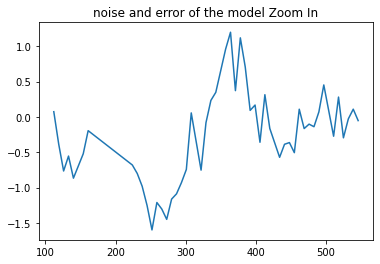

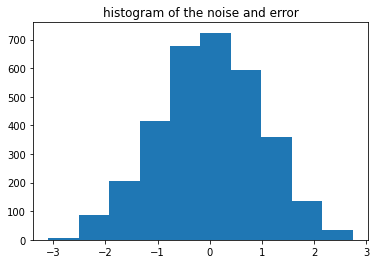

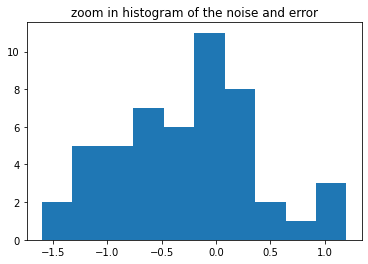

0.8558569639580222


In [39]:
def full_quad_model(time, c0,c1,c2,c3,c4):
  return (c0*(time**2))+c1*time+c2+c3*np.cos(2*math.pi*time/365 + c4)

#coefficients c0,c1,c2
##from the code cell of above, reuse the method of scipy.optimize.curve_fit
cs, cs_var = optimize.curve_fit(full_quad_model, data.epoch, data.CO2)
print(cs, "These are the coefficients")

#now make a seasonal trend
data['seasonal'] = cs[3]*np.cos(2*math.pi*data.epoch/365+cs[4])

#check the data and compare 
major_and_seasonal = np.array(data.function_quad_major + data.seasonal)

#plot the data and the models at once
plt.plot(data.epoch, data.function_quad_major)
plt.plot(data.epoch, data.CO2)
plt.title("data and quadratic major trend")
plt.show()
plt.plot(data.epoch[10:60], data.function_quad_major[10:60]+data.seasonal[10:60])
plt.plot(data.epoch[10:60], data.CO2[10:60])
plt.title("data and quadratic major trend compared with actual data when zoomed in to the graph")
plt.show()
#plot the noise and error
plt.plot(data.epoch, data.function_quad_major+data.seasonal-data.CO2)
plt.title("noise and error of the model (quadratic trend + seasonal trend - actual data)")
plt.show()
plt.plot(data.epoch[10:60], data.function_quad_major[10:60]+data.seasonal[10:60]-data.CO2[10:60])
plt.title("noise and error of the model Zoom In")
plt.show()
#plot the histogram of the noise and error
plt.hist(data.function_quad_major+data.seasonal-data.CO2)
plt.title("histogram of the noise and error")
plt.show()
plt.hist(data.function_quad_major[10:60]+data.seasonal[10:60]-data.CO2[10:60])
plt.title("zoom in histogram of the noise and error")
plt.show()

#calculating r squared
r2_exp = r2_score(data.CO2, data.function_exp_major+data.seasonal)
print(r2_exp)

#interesting... r^2 dropped after adding the seasonal trend... 
#It means that there are more to change for the seasonal trend

In [9]:
#Setting Prior to uniform distribution so that the data drives the inference. 
data.head()

,date,CO2,epoch,function_quad_major,error,function_exp_major,error_exp,seasonal
0,1958-03-29,316.19,0,314.738787,1.451213,337.755714,-21.565714,2.437344
1,1958-04-05,317.31,7,314.753104,2.556896,337.906210,-20.596210,2.601444
2,1958-04-12,317.69,14,314.767431,2.922569,338.018405,-20.328405,2.727817
3,1958-04-19,317.58,21,314.781768,2.798232,338.090690,-20.510690,2.814629
4,1958-04-26,316.48,28,314.796115,1.683885,338.122039,-21.642039,2.860622


Zoom in version of noise+error histogram seems to be not that normal, however, in the overall picture of the histogram, it seems that the noise will be good with normal distribution and thus error will be very small. 

This is because the histogram of noise and what potentially will become an error is symmetrical and uni-modal. It is not bad to guess it is normal distribution. 

So, let's start with Stan and implement the noise as Normal distribution. 

To note, I want the data to drive the project and I don't have any prior knowledge in this field, the prior will be set as a uniform distribution.



In [11]:
#From the quadratic function we already obtained the values for c0~c4
print(cs) #c0, c1, c2, c3 ,c4
print(cs_var) #also from optimization, we know the variance for coefficients. 

#Now build Stan and we will input all these values inside. And the noise will be added by stan with the stan{model}
#to remember what were the coeffs, copy&past&commenting the code from above
#def full_quad_model(time, c0,c1,c2,c3,c4):
#  return (c0*(time**2))+c1*time+c2+c3*np.cos(2*math.pi*time/365 + c4)

[ 9.97919108e-08  2.04985867e-03  3.14734272e+02  2.86832318e+00
 -5.55294339e-01]
[[ 1.89225992e-19 -4.42992611e-15  1.76093524e-11 -5.71471024e-14
   3.91353968e-14]
 [-4.42992611e-15  1.10484327e-10 -4.91795573e-07  1.07636429e-09
  -7.85827344e-10]
 [ 1.76093524e-11 -4.91795573e-07  2.87039531e-03 -9.07098653e-07
   3.16322082e-06]
 [-5.71471024e-14  1.07636429e-09 -9.07098653e-07  5.96097052e-04
   7.11724537e-07]
 [ 3.91353968e-14 -7.85827344e-10  3.16322082e-06  7.11724537e-07
   7.23801462e-05]]


In [31]:
#Stan formatting with the help from Soomin(M22), Idriss(TA)
stan_code = '''

data {
    int<lower=1> data_size;        // number of data points
    int<lower=0> epoch[data_size];  // epoch
    real<lower=0> ppm[data_size];  // CO2 concentration level (ppm)
    real c0_;                   // expected value of c0
    real c1_;                   // expected value of c1
    real c2_;                   // expected value of c2
    real c3_;                   // expected value of c3
    real c4_;                   // expected value of c4
    real<lower = 0> std_mult;               // multiplier to derive standard deviation of coefficients
}

parameters {
    real c0; // parameter for coeff for x^2
    real c1; // parameter for coeff for x^1
    real c2; // parameter for coeff for x^0
    real c3; // parameter for sinusoidal amplitude size
    real c4; // parameter for sinusoidal function that moves parallel to x axis      
    real c5; // parameter for noise - Normal distribution (standard deviation)
}

model {
    for(i in 1:data_size){ 
        ppm[i] ~ normal(c0*pow(epoch[i],2)+c1*epoch[i]+c2+c3*cos(2*pi()*epoch[i]/365 + c4),c5);
    }
    
    c0 ~ normal(c0_,std_mult); // priors of all coefficients
    c1 ~ normal(c1_,std_mult); 
    c2 ~ normal(c2_,std_mult); 
    c3 ~ normal(c3_,std_mult); 
    c4 ~ normal(c4_,std_mult); 
    c5 ~ inv_gamma(1,1);      //inverse gamma as it is a conjugate prior, thus easy to calculate
                              // (1,1) to make it 
}
'''

In [40]:
# input data
stan_data = {
    'data_size': len(data),
    'epoch': data['epoch'],
    'ppm': data['CO2'],
    'c0_':cs[0],
    'c1_':cs[1],
    'c2_':cs[2],
    'c3_':cs[3],
    'c4_':cs[4],
    'std_mult':1.0} #play around with std_mult so that r_hat becomes 1.0

# compile the  model
stan_model = pystan.StanModel(model_code=stan_code)

# train from data and generate posterior samples
results = stan_model.sampling(data=stan_data)
print(results) #yeah, even though I tried std_mult of 1~10 which takes 30 min for every run
#it seems odd due to having some errors from the seasonal trend being off. 
#which has also caused decrease in r^2 too after adding seasonal trend to the major trend


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c344c84f1b253908eeda4e5e2a0d1ab3 NOW.


Inference for Stan model: anon_model_c344c84f1b253908eeda4e5e2a0d1ab3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd    2.5%     25%     50%    75%  97.5%  n_eff   Rhat
c0   -2.8e-5  2.9e-5 4.1e-5 -8.7e-5 -6.2e-5 -2.6e-5 6.0e-6 2.7e-5      2  5.7e4
c1      0.54    0.53   0.76   -0.48   -0.09    0.51   1.18   1.64      2  5.7e4
c2     -0.27    0.93   1.31   -1.11   -1.07   -0.98   0.67   1.99      2  4.0e7
c3      1.63    0.24   0.34    1.19    1.29    1.68   1.96   1.97      2  1.3e7
c4     -0.17     0.8   1.13   -1.74   -1.21   -0.13   0.86   1.32      2  4.0e7
c5      1.54    0.41   0.58     0.8    1.04    1.46   2.04   2.42      2  2.6e4
lp__ -1.9e10  2.1e10 3.0e10 -7.1e10 -4.0e10  -1.8e9 -1.0e9 -9.2e8      2 6098.8

Samples were drawn using NUTS at Fri Dec 17 18:57:19 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reductio

As I've played with the std_mult, it seems that the seasonal trend needs more than what is given. Whatever and however it is fixed and optimized, the result is not reliable + all the predictions are highly correlated with eachother even though the steps are far away. In MCMC, it is supposed to lose its correlation that is far away at least, and converge somewhere. 
The above result is only telling me that the model is not working properly and not converging as well. 

So, let's modify the trend model and re-run stan. As x axis and y axis movement does not seem to be the issue, let's do the diagonal replacement of the sinusoidal wave. I didn't notice this variable until I conducted the Stan and had some time figuring out why the Rhat value does not become 1. 

Also, after discussing the assignment, just noticed that some years have one more days... So, the division should be 365.25 not 365

In [44]:
def revised_full_quad(t,c0,c1,c2,c3,c4,c5):
    return c0+c1*t+c2*t**2+(c3+c4*t)*np.cos(2*math.pi/365.25*t+c5)
cs, cs_var = optimize.curve_fit(revised_full_quad,data['epoch'],data['CO2'])

print('expected values of coefficient:')
for i in cs:
  print(i)
    
data['revised_trend'] = cs[0] + cs[1]*data['epoch'] + cs[2]*data['epoch']**2 + (cs[3]+cs[4]*data['epoch'])* np.cos(2*math.pi/365.25*data['epoch']+cs[5])

#calculating r squared
r2_exp = r2_score(data.CO2, data.revised_trend)
print('r_squared:',r2_exp)

#Ah, much more comfortable r^2 to play with. 
#So, it was to shift the sinumodal wave a bit diagonally after all... 


expected values of coefficient:
314.733809306671
0.0020504517585523884
9.974831015522151e-08
2.5928283056478847
2.349319669384492e-05
-0.41048519121289834
r_squared: 0.9988984816477995


Yikes, let's re-model stan and re run the whole thing. 

In [131]:
uploaded = files.upload() # 파일 업로드 기능 실행

for fn in uploaded.keys(): # 업로드된 파일 정보 출력
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))


Saving CS146 Final Assignment Directed Graph.JPG to CS146 Final Assignment Directed Graph (2).JPG
User uploaded file "CS146 Final Assignment Directed Graph.JPG" with length 62403 bytes


So, this will be the overall hierarchcal model as image below. 

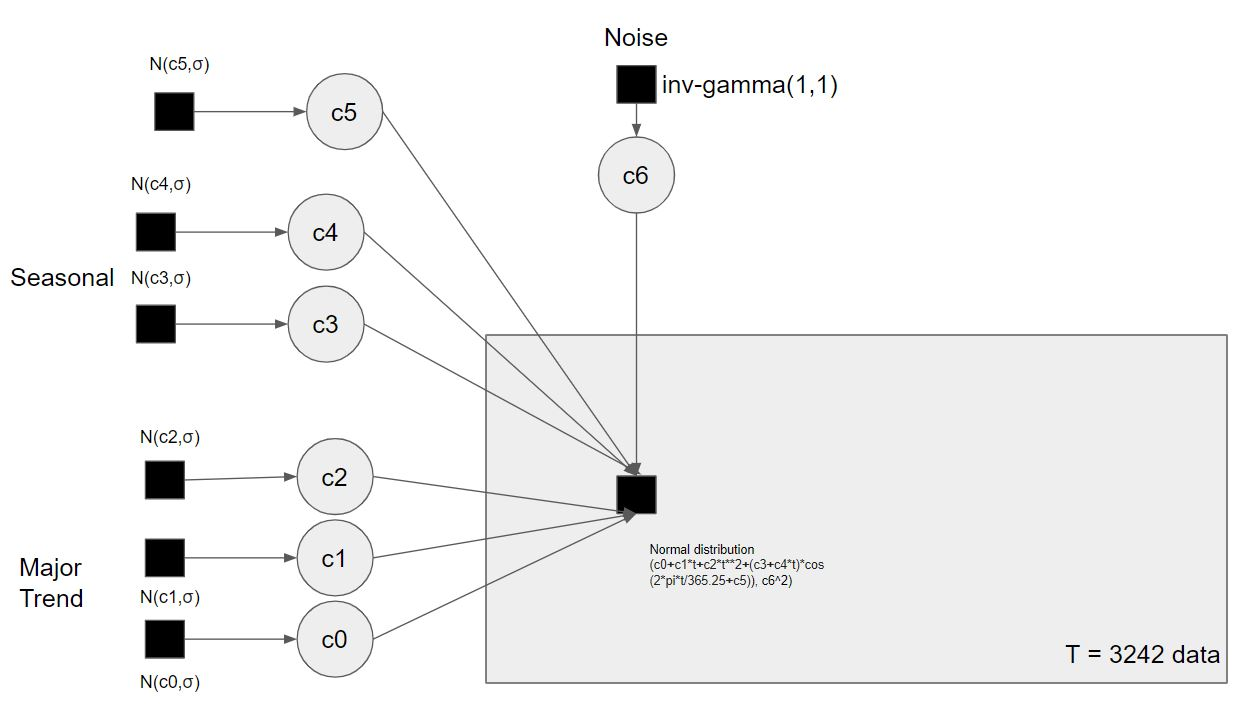

In [132]:
from IPython.display import Image
Image('CS146 Final Assignment Directed Graph.JPG')

In [47]:
stan_code = '''

data {
    int<lower=1> data_size;        // size of the data
    int<lower=0> epoch[data_size];  // epoch
    real<lower=0> ppm[data_size];  // CO2 concentration level
    real c0_;                   
    real c1_;                   
    real c2_;                   
    real c3_;                   
    real c4_;                   
    real c5_;                   
    real std_mult;               // standard deviation for priors
}

parameters {
    real<lower=0> c0; // parameter for x^0
    real<lower=0> c1; // parameter for x^1
    real<lower=0> c2; // parameter for x^2
    real<lower=0> c3; // parameter for sinusoidal function that moves parallel to x axis  
    real<lower=0> c4; // parameter for sinusoidal amplitude 
                      // both c3 and c4 need to be of the same sign for convergence
    real c5; // parameter for sinusoidal phase
    real<lower=0> c6; // noise as standard deviation of normal distribution
}

model {
    for(i in 1:data_size){
        ppm[i] ~ normal(c0+c1*epoch[i]+c2*pow(epoch[i],2)+(c3+c4*epoch[i])*cos(2*pi()*epoch[i]/365.25+c5),c6);
    }
    
    c0 ~ normal(c0_,std_mult); // prior over c0
    c1 ~ normal(c1_,std_mult); // prior over c1
    c2 ~ normal(c2_,std_mult); // prior over c2
    c3 ~ normal(c3_,std_mult); // prior over c3
    c4 ~ normal(c4_,std_mult); // prior over c4
    c5 ~ normal(c5_,std_mult); // prior over c5
    c6 ~ inv_gamma(1,1);        // prior over c6
}
'''

In [52]:
#input data
stan_data = {
    'data_size': len(data),
    'epoch': data['epoch'],
    'ppm': data['CO2'],
    'c0_':cs[0],
    'c1_':cs[1],
    'c2_':cs[2],
    'c3_':cs[3],
    'c4_':cs[4],
    'c5_':cs[5],
    'std_mult':3.0}

# compile the  model
stan_model = pystan.StanModel(model_code=stan_code)

# train from data and generate posterior samples
results = stan_model.sampling(data=stan_data)
print(results)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_638c6c8e4a711853692d91e5ab8e7270 NOW.


Inference for Stan model: anon_model_638c6c8e4a711853692d91e5ab8e7270.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean      sd   2.5%    25%     50%    75%  97.5%  n_eff   Rhat
c0    314.73  1.3e-3    0.05 314.63  314.7  314.73 314.77 314.84   1594    1.0
c1    2.1e-3  2.9e-7  1.1e-5 2.0e-3 2.0e-3  2.1e-3 2.1e-3 2.1e-3   1349    1.0
c2   10.0e-8 1.2e-11 4.4e-10 9.9e-8 9.9e-8 10.0e-8 1.0e-7 1.0e-7   1401    1.0
c3      2.59  9.6e-4    0.05    2.5   2.56    2.59   2.63   2.69   2708    1.0
c4    2.4e-5  7.1e-8  3.7e-6 1.6e-5 2.1e-5  2.4e-5 2.6e-5 3.1e-5   2665    1.0
c5     -0.41  1.8e-4  8.5e-3  -0.43  -0.42   -0.41   -0.4  -0.39   2115    1.0
c6      0.98  2.1e-4    0.01   0.95   0.97    0.98   0.99    1.0   3309    1.0
lp__   -1577    0.05    1.91  -1581  -1578   -1576  -1575  -1574   1610    1.0

Samples were drawn using NUTS at Fri Dec 17 19:39:49 2021.
For each parameter, n_eff is a crude mea

The result above shows the mean, standard deviations, and the confidence intervals as well as Rhat. Having all the Rhat being 1, I feel more comfortable to move on. 
To check if the things are going well, before we plot the predictions, let's see the autocorrelation of the parameters (coefficients). 

OrderedDict([('c0', array([314.82878272, 314.69798817, 314.66313421, ..., 314.63785378,
       314.77587863, 314.66950506])), ('c1', array([0.00204208, 0.00205885, 0.00205831, ..., 0.00205472, 0.00203579,
       0.00205639])), ('c2', array([9.99338084e-08, 9.94057143e-08, 9.95819319e-08, ...,
       9.96958246e-08, 1.00440098e-07, 9.95914511e-08])), ('c3', array([2.59307347, 2.57275106, 2.62569164, ..., 2.58339714, 2.57727614,
       2.58328795])), ('c4', array([2.22804547e-05, 2.58627184e-05, 1.96678594e-05, ...,
       2.33864884e-05, 2.24802749e-05, 2.49171686e-05])), ('c5', array([-0.41020145, -0.40557073, -0.40255417, ..., -0.4157082 ,
       -0.41383006, -0.40707683])), ('c6', array([1.0017423 , 0.98952525, 0.97014995, ..., 0.98813532, 0.96850615,
       0.9715299 ])), ('lp__', array([-1578.57366358, -1574.75122843, -1576.49955633, ...,
       -1580.05062851, -1576.19492106, -1575.24392623]))])
3242


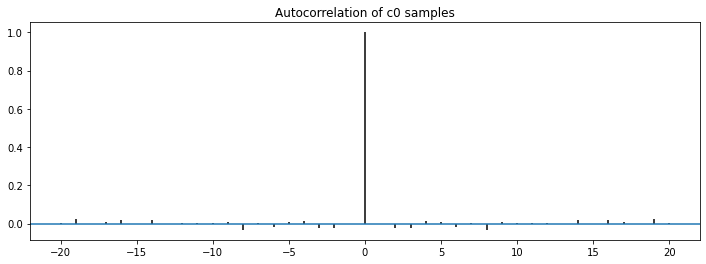

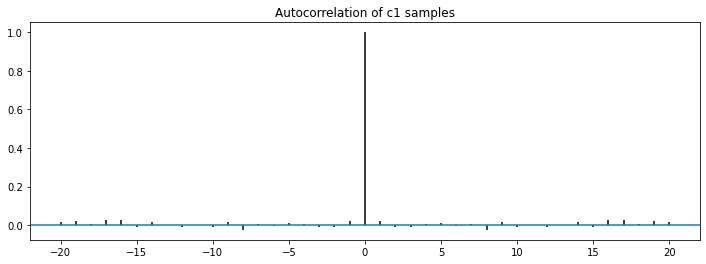

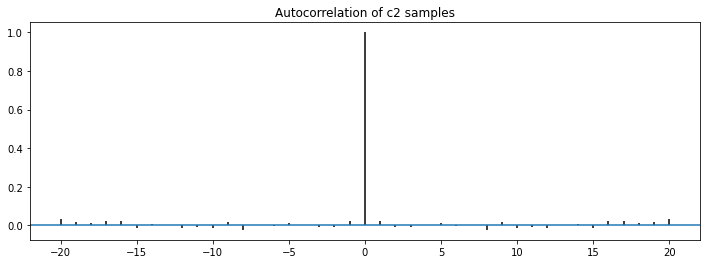

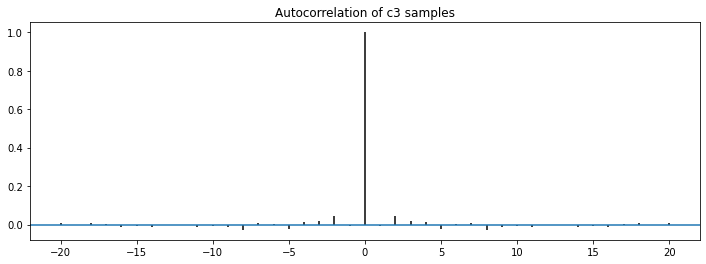

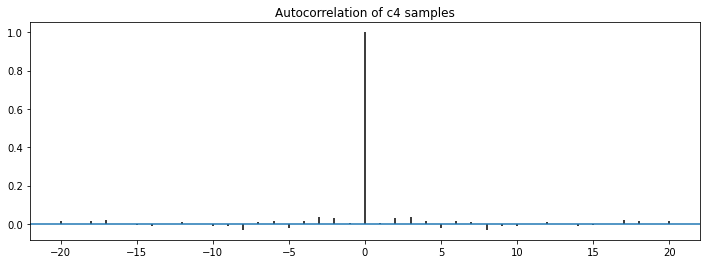

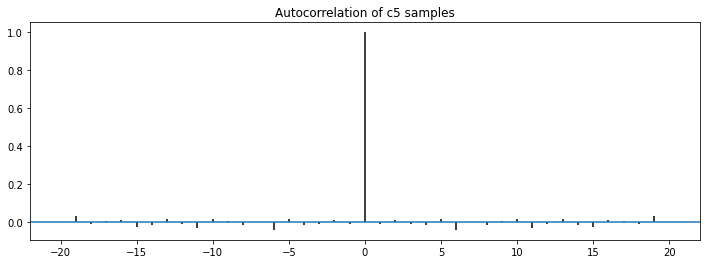

In [71]:
# Plot sample autocorrelation for each parameter.
#Code from class
samples = results.extract()
print(samples)
print(len(data))
parameters = ['c0','c1','c2','c3','c4', 'c5']
def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))

for param in parameters:
    plt.figure(figsize=(12, 4))
    plot_acf(samples[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()


Autocorrection shows that MCMC has been done well too because the correlation between the samples are very low. 

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


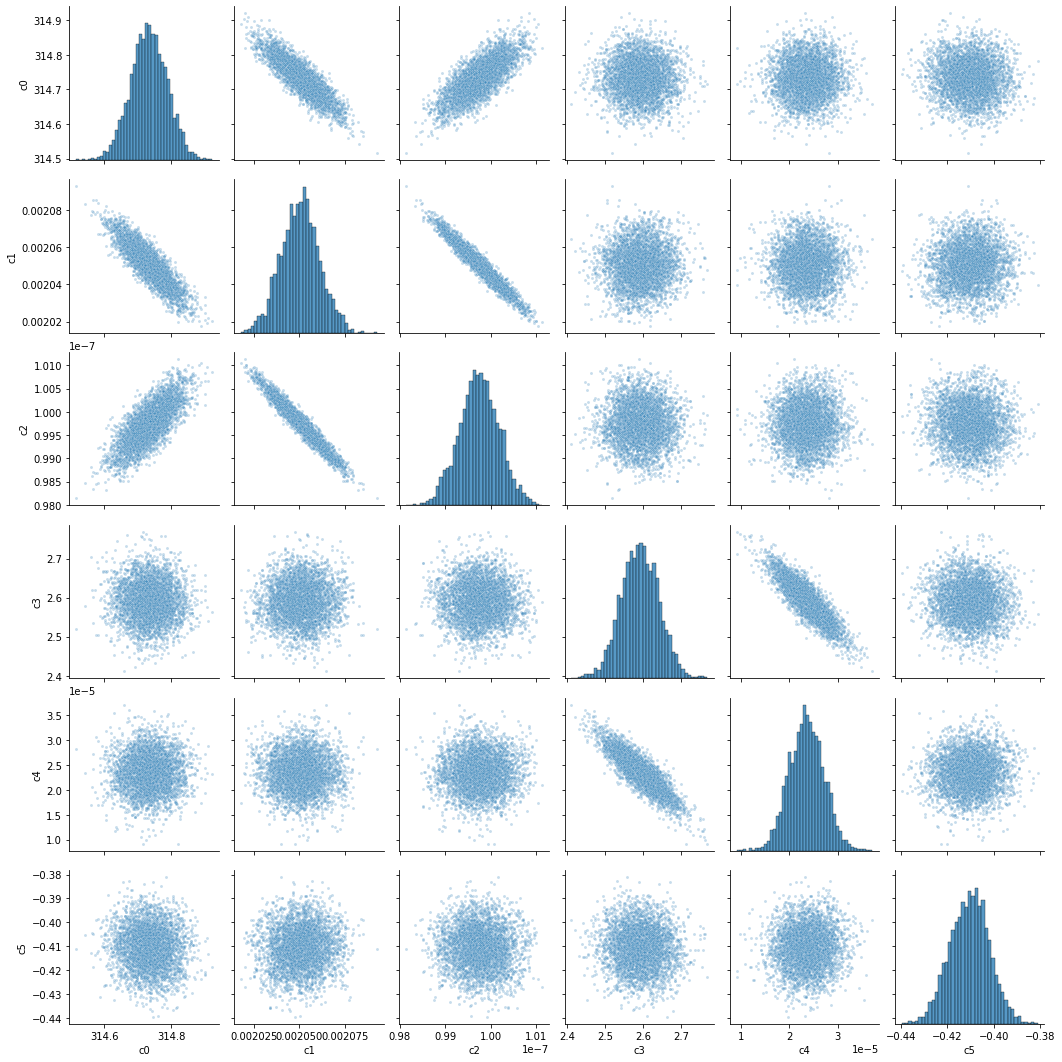

In [66]:
# Make pair plot of the posteriors over all parameters of the model.
df = pd.DataFrame(
    data=np.transpose([samples[param] for param in parameters]),
    columns=parameters)
sns.pairplot(df, size=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

In [129]:

# list of parameters
params = ['c'+str(i) for i in range(7)]

# maximum likelihood trends
paramVals = [summary[0] for summary in results.summary(pars=params)['summary']]
# samples of parameters from the posterior
paramSamples = np.array([results[param] for param in params])

# reshaping so that each element is a vector of parameter samples
vectorSamples = paramSamples.T
# create maximum likelihood estimate predictions
plot_x = data.iloc[-1]['epoch']+7*np.array(range(1390)) #1200 more weeks or prediction
plot_y = paramVals[0]+paramVals[1]*plot_x+paramVals[2]*plot_x**2+\
        (paramVals[3]+paramVals[4]*plot_x)*np.cos(2*math.pi*plot_x/365.25+paramVals[5])

df = pd.DataFrame(data=np.array([plot_x,plot_y]).T,columns=['epoch','CO2'])
print(df)
df['epoch']=df['epoch'].astype(dtype=int)
df['epoch']=pd.to_datetime(df['epoch'],unit='D',origin=data.iloc[0]['epoch'])
df['2.5']=sts.norm.ppf(0.025,loc=df['CO2'],scale=paramVals[6])
df['97.5']=sts.norm.ppf(0.975,loc=df['CO2'],scale=paramVals[6])

df.head()

samples_per_posterior = 5 ## how many samples to take per posterior instance
samples_from_days = 5     ## how many days to give to each posterior for input

# the function to generate samples
def pred_samples(param_vector,sample_days):
    samples=[]
    for day in sample_days:
        sample = sts.norm.rvs(loc=param_vector[0]+param_vector[1]*day+param_vector[2]*day**2+
                              (param_vector[3]+param_vector[4]*day)*
                              np.cos(2*math.pi*day/365.25+param_vector[5]),
                              scale=param_vector[6],size=samples_per_posterior)
        samples+=[(day,samp) for samp in sample]
    return(samples)

# each parameter vector will create 10 samples, according to a random sammple from numWeeks
samples_tuples = []
for i in range(len(vectorSamples)):
    sample_days = data.iloc[-1]['epoch']+7*np.array(random.sample(range(1390),samples_from_days))
    samples_tuples+=pred_samples(vectorSamples[i],sample_days)

samples_tuples=np.array(samples_tuples)

# combine samples into a pandas dataframe
df_pred = pd.DataFrame(data=samples_tuples,columns=['days','CO2 ppm'])
df_pred['days']=df_pred['days'].astype(dtype=int)
df_pred['date']=pd.to_datetime(df_pred['days'],unit='D',origin=data.iloc[0]['epoch'])
df_pred.sort_values(by='date',inplace=True)
df_pred.reset_index(inplace=True,drop=True)

df_pred.head()

        epoch         CO2
0     23191.0  413.109469
1     23198.0  413.012100
2     23205.0  412.957713
3     23212.0  412.947780
4     23219.0  412.983125
...       ...         ...
1385  32886.0  493.356216
1386  32893.0  493.464354
1387  32900.0  493.523826
1388  32907.0  493.534639
1389  32914.0  493.497504

[1390 rows x 2 columns]


,days,CO2 ppm,date
0,23191,411.908417,2033-06-30
1,23191,411.929026,2033-06-30
2,23191,413.280596,2033-06-30
3,23191,412.313339,2033-06-30
4,23191,412.744034,2033-06-30


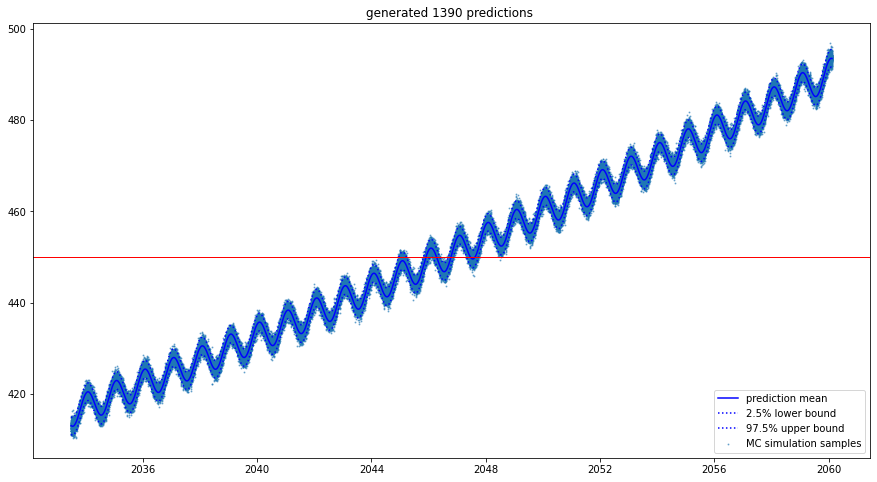

450.0 ppm reached by 97.5% upper bound value on 2044-12-15
450.0 ppm reached by prediction mean value on 2045-11-30
450.0 ppm reached by 2.5% lower bound value on 2046-01-25


In [149]:
plt.figure(figsize = (15,8))

plt.scatter(df_pred['date'],df_pred['CO2 ppm'],s=1,alpha=0.5)
plt.plot(df['epoch'],df['CO2'],color='blue')
plt.plot(df['epoch'],df['2.5'],color='blue',linestyle=':')
plt.plot(df['epoch'],df['97.5'],color='blue',linestyle=':')
plt.legend(['prediction mean','2.5% lower bound','97.5% upper bound','MC simulation samples'],
           loc='lower right')
bounds = ['97.5% upper bound','prediction mean','2.5% lower bound']
# plot relevant lines
critical_ppm = 450.0
plt.axhline(critical_ppm,color='red',lw=1.0)
plt.title("generated 1390 predictions ")
plt.show()

#find when it reaches the 'danger zone 450 ppm'
when = [df[df['97.5']>critical_ppm]['epoch'].iloc[0],
                 df[df['CO2']>critical_ppm]['epoch'].iloc[0],
                 df[df['2.5']>critical_ppm]['epoch'].iloc[0]]

for i in range(len(when)):
    print('%.1f ppm reached by %s value on %s'
          %(critical_ppm,bounds[i],when[i].strftime('%Y-%m-%d')))

In [128]:
print(df[13])

          epoch         CO2         2.5        97.5
1383 2060-01-01  492.997425  491.081178  494.913672
1384 2060-01-08  493.200108  491.283861  495.116355


So, by the start of 2060-01-01, the CO2 level will be [491.08, 494.91] on 95% Confidence Interval while the best estimate of CO2 level is 492.997ppm as the table above shows. 

And 450ppm will be hit on 2044-12-15 ~ 2046-01-25 (95% confidence interval) while there is 50% chance that it'll be 2045-11-30. 

There is a shortcomming of this model that it may be way too simple for the noise as I've used inverse gamma distribution to represent the standard deviation of the likelihood, which is a normal distribution. If there is a better choice for noise, results may change. Also, it seems more reasonble to think of the confidence interval of the prediction to widen as it gets furthur into the distance away from the observed data. However, in this model, as I've set a constant mean for the coefficients, it has somewhat similar range of confidence interval overall in the future, which means that 2022's confidence interval is about the same in size with 2060. So, the result of the far future may not be a good prediction as the actual confidence interval is likely to be bigger than that and thus the time when we reach the 450 ppm may be different from what I've got as the result. 

Lastly, if I had some prior knowledge about this, I could have set up more relevant prior which may have a totally different result depending on the situation and what the relevant prior will be rather than uniform from this assignment. 

### Reference
Andrew Gelman. 2006. Prior distributions for variance parameters in hierarchical models. Bayesian Analysis 1(3), pp 515-533
[link to the pdf: http://www.stat.columbia.edu/~gelman/research/published/taumain.pdf ]

(My Codes are also available at https://colab.research.google.com/drive/1ZERxMlnBorH1rs1kHUsWUSGxJqBQIVKm#scrollTo=LZfDcG4FSK8C Just in case if it does not work, try on google colab. Because the whole thing is built for colab environment including the file uploading methods). 

### HC Applications

Confidence Intervals: Confidence intervals were generated and shown from the future prediction. This was possible due to the model having noise introduced. Also, the interpretation of it was made when the model reaches the dangerous CO2 level '450ppm' 

descriptive stats: stan has generated mean, standard deviation, 95% confidence intervals, and even the 25,50, and 75% quantiles for better understanding of each coefficients. These values were used to make predictions!

distributions: Knowing the characteristics of the distribution, prior, likelihood were made and selected, so that calculations can become easy!

correlation: by understanding the fundamentals of the correlation, we get to know what is a good model by generating autocorrelation graphs.

